In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from urllib import urlretrieve
import cPickle as pickle
import os
import gzip

import numpy as np
import theano

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import softmax


from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 98.0% of memory, CuDNN not available)
/home/ubuntu/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import softmax

from nolearn.lasagne import NeuralNet

from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

In [3]:
def load_CIFAR_file(filename):  
    '''Load a single file of CIFAR'''
    with open(filename, 'rb') as f:
        datadict= pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype('float32')
        Y = np.array(Y).astype('int32')
        return X, Y


def load_CIFAR10(directory):  
    '''Load all of CIFAR'''
    xs = []
    ys = []
    for k in range(1,6):
        f = os.path.join(directory, "data_batch_%d" % k)
        X, Y = load_CIFAR_file(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    Xte, Yte = load_CIFAR_file(os.path.join(directory, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [4]:
def load_CIFAR_meta():
    filename = '/home/ubuntu/Notebooks/data/cifar-10-batches-py/batches.meta'
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        label_names = datadict['label_names']
        return label_names

Load data

In [ ]:
cifar10_dir = "/home/ubuntu/Notebooks/data/cifar-10-batches-py"
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [5]:
label_names = load_CIFAR_meta()
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


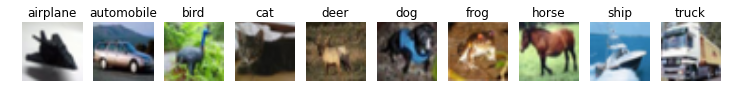

In [29]:
fig,ax = plt.subplots(1, 10)
fig.set_size_inches(12.5, 3.5)
for x in range(1, 11):
    i  = np.argwhere(y_train==x-1)[0][0]
    ax[x - 1].imshow(-X_train[i])
    ax[x - 1].axis('off')
    ax[x - 1].set_title(label_names[y_train[i]])

Transform images into black/white

In [30]:
X_train_2d = np.dot(X_train[...,:3], [0.299, 0.587, 0.114]).reshape(-1,1,32,32).astype(np.float32)
X_test_2d = np.dot(X_test[...,:3], [0.299, 0.587, 0.114]).reshape(-1,1,32,32).astype(np.float32)

X_train_2d = (X_train_2d /255.0)-0.5
X_test_2d = (X_test_2d/255.0)-0.5

Layout of neural network

In [31]:
net2 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 1, 32, 32),
    # layer conv2d1
    conv2d1_num_filters=64,
    conv2d1_filter_size=(5, 5),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),  
    # layer maxpool1
    maxpool1_pool_size=(2, 2),    
    # layer conv2d2
    conv2d2_num_filters=128,
    conv2d2_filter_size=(5, 5),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # dropout1
    dropout1_p=0.5,    
    # dense
    dense_num_units=256,
    dense_nonlinearity=lasagne.nonlinearities.rectify,    
    # dropout2
    dropout2_p=0.5,    
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=10,
    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=100,
    verbose=2,
    )

In [32]:
net2.initialize()

/home/ubuntu/anaconda/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [33]:
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()

Visualize layout

In [34]:
layer_info(net2)

# Neural Network with 1028618 learnable parameters

## Layer information

name      size         total    cap.Y    cap.X    cov.Y    cov.X
--------  ---------  -------  -------  -------  -------  -------
input     1x32x32       1024   100.00   100.00   100.00   100.00
conv2d1   64x28x28     50176   100.00   100.00    15.62    15.62
maxpool1  64x14x14     12544   100.00   100.00    15.62    15.62
conv2d2   128x10x10    12800    76.92    76.92    40.62    40.62
maxpool2  128x5x5       3200    76.92    76.92    40.62    40.62
dropout1  128x5x5       3200   100.00   100.00   100.00   100.00
dense     256            256   100.00   100.00   100.00   100.00
dropout2  256            256   100.00   100.00   100.00   100.00
output    10              10   100.00   100.00   100.00   100.00

Explanation
    X, Y:    image dimensions
    cap.:    learning capacity
    cov.:    coverage of image
    magenta: capacity too low (<1/6)
    cyan:    image coverage too high (>100%)
    red:     capacity to

Train

In [35]:
net2.fit(X_train_2d, y_train)

# Neural Network with 1028618 learnable parameters

## Layer information

name      size         total    cap.Y    cap.X    cov.Y    cov.X
--------  ---------  -------  -------  -------  -------  -------
input     1x32x32       1024   100.00   100.00   100.00   100.00
conv2d1   64x28x28     50176   100.00   100.00    15.62    15.62
maxpool1  64x14x14     12544   100.00   100.00    15.62    15.62
conv2d2   128x10x10    12800    76.92    76.92    40.62    40.62
maxpool2  128x5x5       3200    76.92    76.92    40.62    40.62
dropout1  128x5x5       3200   100.00   100.00   100.00   100.00
dense     256            256   100.00   100.00   100.00   100.00
dropout2  256            256   100.00   100.00   100.00   100.00
output    10              10   100.00   100.00   100.00   100.00

Explanation
    X, Y:    image dimensions
    cap.:    learning capacity
    cov.:    coverage of image
    magenta: capacity too low (<1/6)
    cyan:    image coverage too high (>100%)
    red:     capacity to

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f6ef55e8ad0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f6ef55e8990>,
     conv2d1_W=<lasagne.init.GlorotUniform object at 0x7f6ef2179ad0>,
     conv2d1_filter_size=(5, 5),
     conv2d1_nonlinearity=<function rectify at 0x7f6ef6c68578>,
     conv2d1_num_filters=64, conv2d2_filter_size=(5, 5),
     conv2d2_nonlinearity=<function rectify at 0x7f6ef6c68578>,
     conv2d2_num_filters=128, custom_scores=None,
     dense_nonlinearity=<function rectify at 0x7f6ef6c68578>,
     dense_num_units=256, dropout1_p=0.5, dropout2_p=0.5,
     input_shape=(None, 1, 32, 32),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv2d1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('maxpool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2d2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('maxpool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), 

In [36]:
y_pred1 = net2.predict(X_test_2d)

In [37]:
print(y_pred1[0:10])
print(y_test[0:10])

[3 8 8 0 6 6 9 6 3 9]
[3 8 8 0 6 6 1 6 3 1]


In [38]:
print(accuracy_score(y_test, y_pred1))

0.7521


/home/ubuntu/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


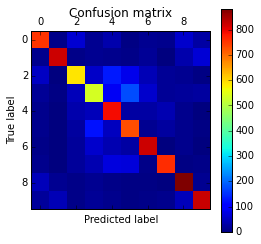

In [40]:
cm = confusion_matrix(y_test, y_pred1)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
y_matrix = np.vstack((y_test, y_pred1)).T

[3 3]


In [58]:
print(y_matrdix)

[[3 3]
 [8 8]
 [8 8]
 ..., 
 [5 5]
 [1 4]
 [7 7]]


Incorrectly predicted as bird

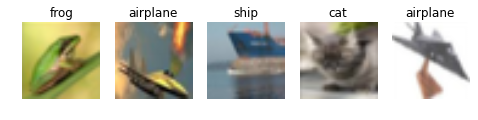

In [85]:
inc_bird_labs = np.argwhere(np.logical_and(y_matrix[:,0] != 2, y_matrix[:,1] == 2 ))[0:5]
fig,ax = plt.subplots(1, 5)
fig.set_size_inches(8, 3.5)
for x in range(1, 6):
    i  = inc_bird_labs[x - 1][0]
    ax[x - 1].imshow(-X_test[i])
    ax[x - 1].axis('off')
    ax[x - 1].set_title(label_names[y_test[i]])

Incorrectly predicted as cat

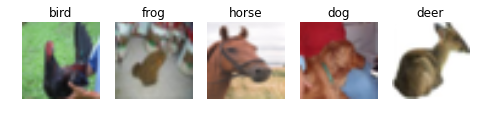

In [88]:
inc_cat_labs = np.argwhere(np.logical_and(y_matrix[:,0] != 3, y_matrix[:,1] == 3 ))[0:5]
fig,ax = plt.subplots(1, 5)
fig.set_size_inches(8, 3.5)
for x in range(1, 6):
    i  = inc_cat_labs[x - 1][0]
    ax[x - 1].imshow(-X_test[i])
    ax[x - 1].axis('off')
    ax[x - 1].set_title(label_names[y_test[i]])

Supposed to predict cat, did not

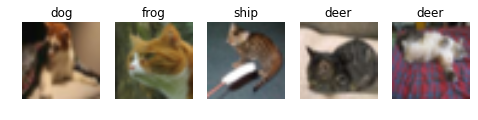

In [89]:
inc_cat_labs = np.argwhere(np.logical_and(y_matrix[:,0] == 3, y_matrix[:,1] != 3 ))[0:5]
fig,ax = plt.subplots(1, 5)
fig.set_size_inches(8, 3.5)
for x in range(1, 6):
    i  = inc_cat_labs[x - 1][0]
    ax[x - 1].imshow(-X_test[i])
    ax[x - 1].axis('off')
    ax[x - 1].set_title(label_names[y_pred1[i]])

In [90]:
corr_cat_labels = np.argwhere(np.logical_and(y_matrix[:,0] == 3, y_matrix[:,1] == 3 ))[0:5]
print(corr_cat_labels)

[[ 0]
 [ 8]
 [46]
 [53]
 [63]]


<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

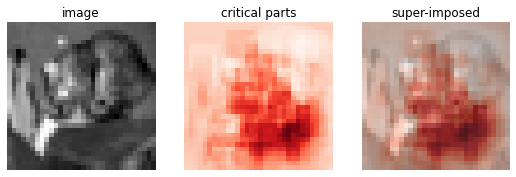

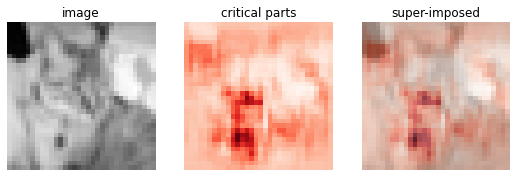

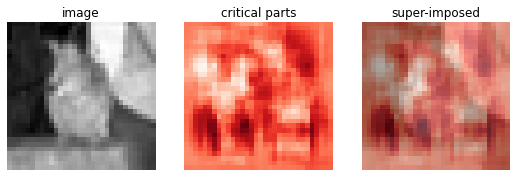

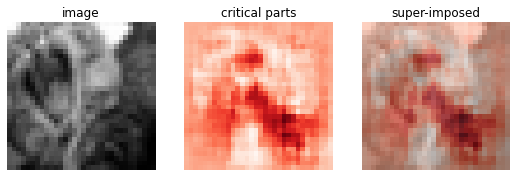

In [91]:
visualize.plot_occlusion(net2, X_test_2d[0:1], y_test[0:1])
visualize.plot_occlusion(net2, X_test_2d[8:9], y_test[8:9])
visualize.plot_occlusion(net2, X_test_2d[46:47], y_test[46:47])
visualize.plot_occlusion(net2, X_test_2d[53:54], y_test[53:54])

In [36]:
print(accuracy_score(y_test, y_pred1))

0.7482
